<img src="https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/nb_logo.png?raw=1" width="600">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/prot_design.ipynb)


This is a version of the notebook from [Martin Pacesa](https://people.epfl.ch/martin.pacesa) --- [here](https://colab.research.google.com/drive/15ucZMtrAeFE_YOBQ9FdrWlAngvljJ4ss?usp=sharing) and [ESMFold](https://github.com/facebookresearch/esm/tree/main/esm/esmfold/v1) -- [here](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/ESMFold.ipynb)

# ProtGPT2

ProtGPT2 ([Ferruz et al 2022](https://www.nature.com/articles/s41467-022-32007-7)) is a language model trained on the protein space that generates de novo protein sequences following the principles of natural ones. The generated proteins display natural amino acid propensities, distantly related to natural ones, as well as unexplored regions of protein space. AlphaFold prediction of ProtGPT2-sequences yields well-folded non-idealized structures with embodiments and large loops and reveals topologies not captured in current structure databases. ProtGPT2 generates sequences in a matter of seconds and is freely available through [Huggin Face](https://huggingface.co/nferruz/ProtGPT2).

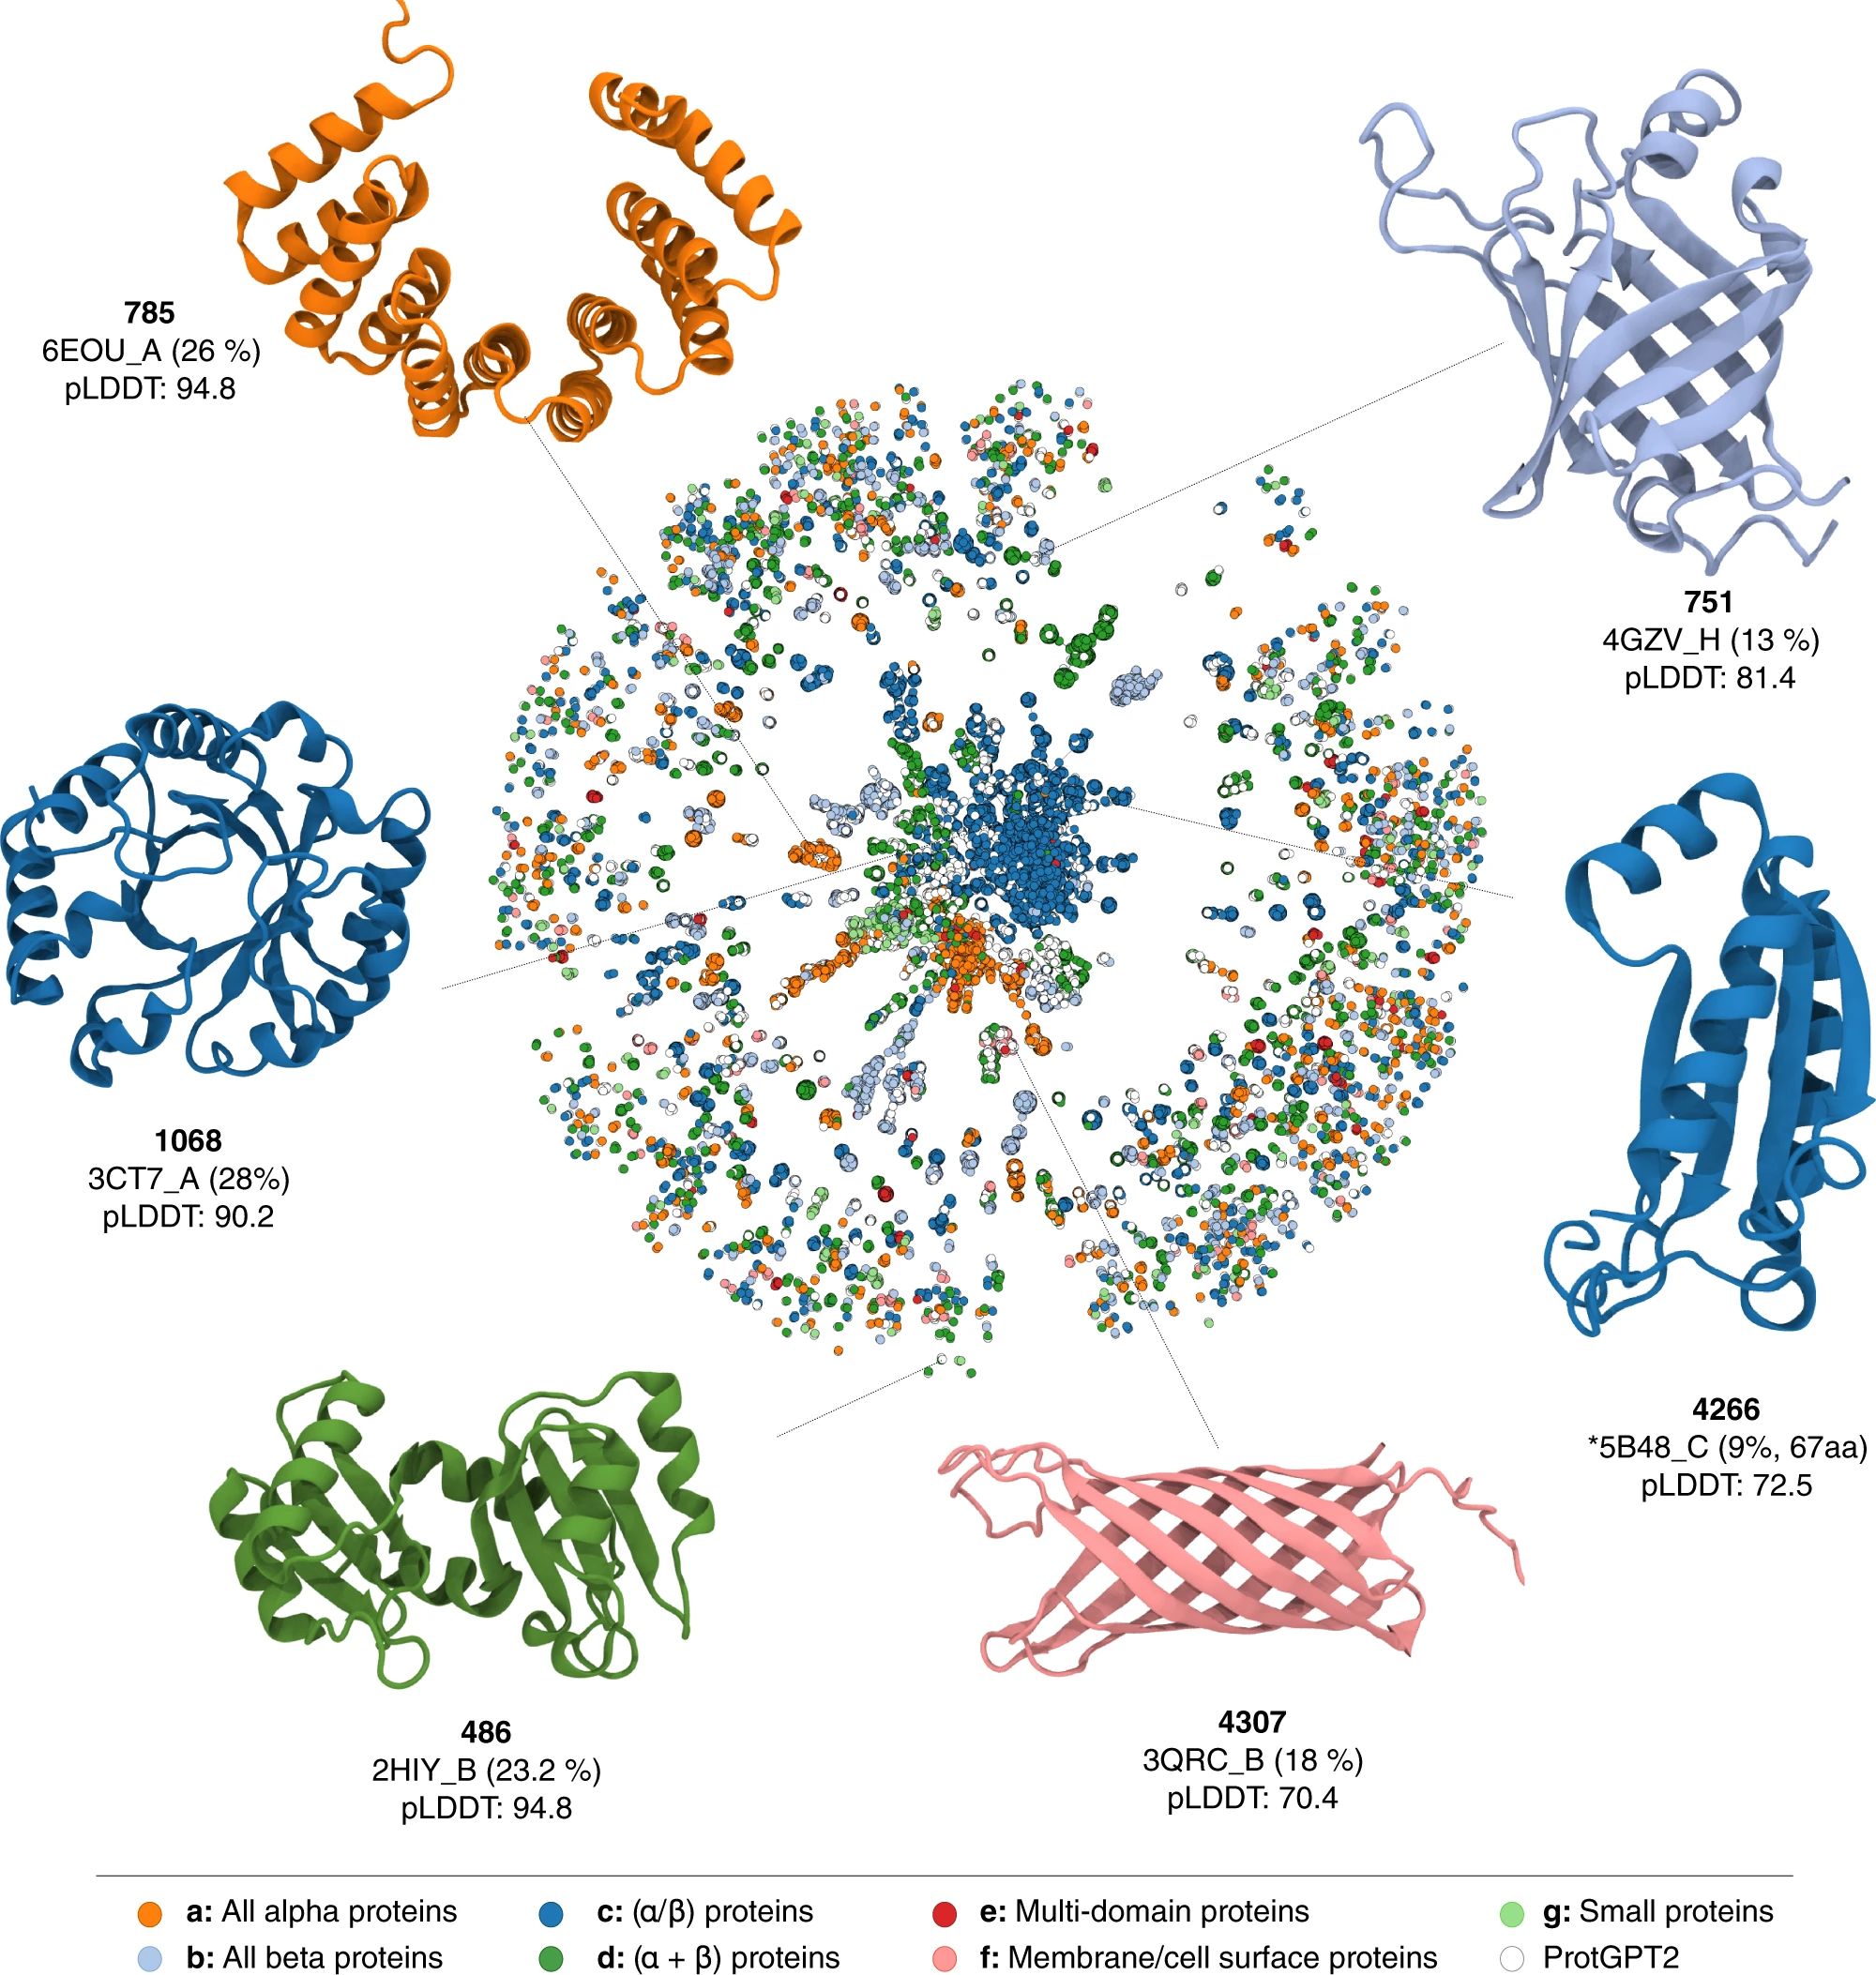


In [2]:
!pip install "transformers[torch]" biopython pymsaviz > /dev/null
!apt-get install muscle &> /dev/null

In [5]:
import transformers
#initialise language model
protgpt2 = transformers.pipeline('text-generation', model="nferruz/ProtGPT2")

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [6]:
# Model parameters

project_name = "pML_course"
starting_sequence = "MIQEKDKYVVASVTILESNQ"
sequence_min_length = len(starting_sequence)
sequence_max_length = 3 * len(starting_sequence)
number_of_generated_sequences = 20


#Randomly pick the next amino acid according to its conditional probability distribution? (non-deterministic)
do_random_sampling = True

#Controls randomness in boltzman distribution. Lower temperature results in less random completions. 
#As the temperature approaches zero, the model will become deterministic and repetitive. 
#Higher temperature results in more random completions.
sampling_temperature = 1.0

#Controlls diversity. 1 means only 1 amino acid with highest probability is considered for each step (token),
#resulting in deterministic completions while 950 means 950 amino acids with highest probability are considered at each step. 
#0 is a special setting meaning no restrictions.
top_k_sampling = 950

#Controlls diversity. Samples from the smallest possible set of probable amino acids whose cumulative probability exceeds 
#the probability defined.
top_p_filtering = 1.0

#Repetition penalty.
penalty_for_repetition = 1.2 #@param {type:"number"}

#Correction factor used for sequence length.
#GPT2 measures length in tokens, not amino acids, therefore generated sequences are 3-4 times longer than specified.
#You can either use the empirically determined 3.2x correction factor (Default), or none (1), or let the script calculate
#the exact factor needed for your specified parameters, however this will result in double the running time.
correction_factor = 3.2



seed =  423

# Sequence Generation

In [7]:
#set seed for reproducibility
transformers.set_seed(seed)

#correct sequence lengths
corrected_sequence_min_length = int(sequence_min_length/correction_factor, )
corrected_sequence_max_length = int(sequence_max_length/correction_factor, )

#generate sequences
sequences = protgpt2(starting_sequence, 
                     min_length=corrected_sequence_min_length, 
                     max_length=corrected_sequence_max_length, 
                     do_sample=do_random_sampling, 
                     top_k=top_k_sampling, 
                     top_p=top_p_filtering, 
                     temperature=sampling_temperature, 
                     repetition_penalty=penalty_for_repetition, 
                     num_return_sequences=number_of_generated_sequences, 
                     batch_size=1, eos_token_id=0)
print("Sequences generated")

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Sequences generated


In [8]:
sequences

[{'generated_text': 'MIQEKDKYVVASVTILESNQNE\nKNYFDKIACYFCNQHQWIEKAG'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQTV\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQELIDYE\nKPIMEMEVIEQRWKIIYKLIT'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQKKENDCFYS\nLSHPKKSYYAGLKIWNE'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQKVAVSINNAISSTLSVSNITITNIKNNSAS'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQFENVQSIFLGNDKVITGLVNNDEGIVHFIE'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQWHINYPIPSDFLIATELTVDNYTFSKN\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQYD\nGEYAVTISDFNTKSKGVEEIYNRIWG'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQFESGGDNLPKGMDFMKEKAQIT\nRSKVI'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQAVGNQ\nAVLYSLVKQKEKWMINDFSYI'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQIHT\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQTVPGSRLAYLNSPRDDWQSGVIEIFWD'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQYD\nFSGSTINVNGVI\n'},
 {'generated_text': 'MIQEKDKYVVASVTILESNQIVCLERTKALSSEILACLQALLIAIKYKLTNVWL'},
 {'generated_text': 'MI

In [11]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

fastaname = project_name+"_seed"+str(start_seedn)+".fa"
records = []
for idx, sequence in enumerate(sequences):
    record = SeqRecord(Seq(sequence), 
                       id=str(idx), 
                       name=project_name + str(idx), 
                       description="ProtGPT2 generated sequence from " + starting_sequence)
    records.append(record)

with open(fastaname, "w") as output_handle:
    SeqIO.write(records, output_handle, "fasta")

ImportError: dlopen(/Users/albsad/miniconda3/envs/pml_env/lib/python3.11/site-packages/Bio/Align/_aligners.cpython-311-darwin.so, 0x0002): tried: '/Users/albsad/miniconda3/envs/pml_env/lib/python3.11/site-packages/Bio/Align/_aligners.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/albsad/miniconda3/envs/pml_env/lib/python3.11/site-packages/Bio/Align/_aligners.cpython-311-darwin.so' (no such file), '/Users/albsad/miniconda3/envs/pml_env/lib/python3.11/site-packages/Bio/Align/_aligners.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

In [ ]:
from Bio.Align.Applications import MuscleCommandline
from Bio import AlignIO

fastaname_aligned = fastaname.replace(".fa", "_aligned.aln")
align_muscle = MuscleCommandline(input=fastaname, out=fastaname_aligned)
stdout, stderr = align_muscle()
alignment = AlignIO.read(fastaname_aligned, "fasta")
files.download(fastaname_aligned)
print("Alignment generated")

In [ ]:
from pymsaviz import MsaViz, get_msa_testdata

mv = MsaViz(alignment)
fig = mv.plotfig()

In [ ]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBList import PDBList

p = PDBParser(PERMISSIVE=1)

In [12]:
import requests

headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
    }

pdb_files = []
for record in records:
    response = requests.post('https://api.esmatlas.com/foldSequence/v1/pdb/', headers=headers, data=record.seq)
    name = record.name
    pdb_string = response.content.decode('utf-8')
    
    with open(name+'.pdb', 'w') as f:
        f.write(pdb_string)
    
    pdb_files.append(name+'.pdb')

NameError: name 'records' is not defined

In [ ]:
for pdb_file in pdb_files:
    view=py3Dmol.view()
    view.addModel(open(pdb_file, 'r').read(),'pdb')
    view.zoomTo()
    view.setBackgroundColor('white')
    #Here we set the visualization style for chain B and C
    view.setStyle({'cartoon': {'color':'yellow'}})
    view.show()